In [251]:
#import required package
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import spectral.io.envi as envi
import spectral
import os
import re
import math
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import minmax_scale
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [252]:
#import required package
from __future__ import division
from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import os
import re
import math
import PIL
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.metrics import r2_score
#from osgeo import gdal
from pysptools import spectro
from collections import Counter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [253]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses(parentDirectory):
    observationFiles=[]
    
    for (dirpath, dirnames, filenames) in os.walk(parentDirectory):
        observationFiles.extend(filenames)
        break
    ObservationImageAddresses=[]
    
    hdrPattern=".hdr"
    for i in observationFiles:
        if re.search(hdrPattern,i):
            ObservationImageAddresses.append(parentDirectory+'/'+i)
    return ObservationImageAddresses

In [254]:
# return an array of objects of SLI files corresponding to different mineral spectra
def getspectralObjects(spectraDirectory):
    observationFiles=[]
    for (_,_,temporaryList) in os.walk(spectraDirectory):
        observationFiles.extend(temporaryList)
        break
    hdrPattern=".hdr$"
    spectralObjects=[]
    for i in observationFiles:
        if re.search(hdrPattern,i):
            currentFile=spectraDirectory+'/'+i
            currentSpectra=envi.open(currentFile)
            spectralObjects.append(currentSpectra)
    return spectralObjects,observationFiles

In [255]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [256]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [257]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [258]:
#given a spectral object and a wavelength list extract spectra resample them to the given wavelenght list resolution
def getResampledSpectra(spectralObject,wavelengthList):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    #find no of bands in CRISM image
    noOfBands=np.shape(wavelengthList)[0] 
    # calculate number of spectras
    noOfSpectra=np.shape(spectras)[0]
    # create an array to store the resampled spectras
    resampledSpectras=np.zeros((noOfSpectra,noOfBands))
    #create a resampler
    resampler=BandResampler(sourceWavelengthList,wavelengthList)
    #iterate over all spectra
    for i in range(noOfSpectra):
        #resample a spectra
        resampledSpectras[i,:]=resampler(spectras[i,:])
    return resampledSpectras,spectralObject.names

In [259]:
#given spectral object get original spectra and accompaning wavelength list
def getOriginalSpectra(spectralObject):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    
    return spectras,spectralObject.names,sourceWavelengthList

In [260]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [261]:
#calculate mean relfectance at wavelength with defined kernel size for datacube
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [262]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    upperLimit=1
    lowerLimit=0.0000001
    maximumValue=np.amax(spectra)
    minimumValue=np.amin(spectra)
    normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
    return normalizedSpectra

In [263]:
#calculate mean relfectance at wavelength with defined kernel size 
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [264]:
#calculate mean relfectance at wavelength with defined kernel size for an array of spectra
def calcualteReflectaneAtWavelengthSpectraArray(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [265]:
#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateMIN23AND25():
    
    global datacube
    global wavelengthList
    
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calcualteReflectaneAtWavelength(R2295Wavelength,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calcualteReflectaneAtWavelength(R2165Wavelength,R2165KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelength(R2364Wavelength,R2364KernelSize)
    R2480Reflectance=calcualteReflectaneAtWavelength(R2480Wavelength,R2480KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelength(R2570Wavelength,R2570KernelSize)

    temp1Den=np.add(aForR2165*R2165Reflectance,bForR2364*R2364Reflectance) # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=np.add(aForR2364*R2364Reflectance,bForR2570*R2570Reflectance)
    temp3=np.full_like(R2570Reflectance,2.0)
    
    temp1=np.divide(R2295Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2570Reflectance,1),temp1)
    temp3=np.full_like(R2570Reflectance,2.0)
    temp2=np.divide(R2480Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2570Reflectance,1),temp2)
    MIN2295_2480=np.minimum(temp1,temp2)
    
    R2345Reflectance=calcualteReflectaneAtWavelength(R2345Wavelength,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calcualteReflectaneAtWavelength(R2250Wavelength,R2250KernelSize)
    R2430Reflectance=calcualteReflectaneAtWavelength(R2430Wavelength,R2430KernelSize)
    R2537Reflectance=calcualteReflectaneAtWavelength(R2537Wavelength,R2537KernelSize)
    R2602Reflectance=calcualteReflectaneAtWavelength(R2602Wavelength,R2602KernelSize)
    
    temp1Den=np.add(aForR2250*R2250Reflectance,bForR2430*R2430Reflectance) # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=np.add(aForR2430*R2250Reflectance,bForR2602*R2602Reflectance)
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=np.divide(R2345Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2345Reflectance,1),temp1)
    temp3=np.full_like(R2345Reflectance,2.0)
    temp2=np.divide(R2537Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2345Reflectance,1),temp2)
    MIN2345_2537=np.minimum(temp1,temp2)
    
    return MIN2295_2480,MIN2345_2537

In [266]:
#create a function to calculate BD2500H
def calcBD2500_2():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2480Wavelength=2.480
    R2364Wavelength=2.364
    R2570Wavelength=2.570
    
    #define the kernel size for smoothing at the wavelengths
    R2570KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2570Wavelength-R2480Wavelength)/(R2570Wavelength-R2364Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2480Reflectance=calcualteReflectaneAtWavelength(R2480Wavelength,R2480KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelength(R2364Wavelength,R2364KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelength(R2570Wavelength,R2570KernelSize)
    BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)
    return BD2500_2

In [267]:
#create a function to calculate BD2500H
def calcBD2290():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2290Wavelength=2.290
    R2250Wavelength=2.250
    R2350Wavelength=2.350
    
    #define the kernel size for smoothing at the wavelengths
    R2350KernelSize=5
    R2250KernelSize=5
    R2290KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2350Wavelength-R2290Wavelength)/(R2350Wavelength-R2250Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2290Reflectance=calcualteReflectaneAtWavelength(R2290Wavelength,R2290KernelSize)
    R2250Reflectance=calcualteReflectaneAtWavelength(R2250Wavelength,R2250KernelSize)
    R2350Reflectance=calcualteReflectaneAtWavelength(R2350Wavelength,R2350KernelSize)
    BD2290=1-R2290Reflectance/(a*R2250Reflectance+b*R2350Reflectance)
    return BD2290

In [268]:
#create a function to calculate BD2500H
def calcBD2355():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2355Wavelength=2.350
    R2300Wavelength=2.300
    R2450Wavelength=2.450
    
    #define the kernel size for smoothing at the wavelengths
    R2450KernelSize=5
    R2300KernelSize=5
    R2355KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2450Wavelength-R2355Wavelength)/(R2450Wavelength-R2300Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2355Reflectance=calcualteReflectaneAtWavelength(R2355Wavelength,R2355KernelSize)
    R2300Reflectance=calcualteReflectaneAtWavelength(R2300Wavelength,R2300KernelSize)
    R2450Reflectance=calcualteReflectaneAtWavelength(R2450Wavelength,R2450KernelSize)
    BD2355=1-R2355Reflectance/(a*R2300Reflectance+b*R2450Reflectance)
    return BD2355

In [269]:


#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateMIN23AND25Spectra():
    
    global datacube
    global wavelengthList
    
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2295Wavelength,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2165Wavelength,R2165KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2364Wavelength,R2364KernelSize)
    R2480Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2480Wavelength,R2480KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2570Wavelength,R2570KernelSize)

    temp1Den=np.add(aForR2165*R2165Reflectance,bForR2364*R2364Reflectance) # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=np.add(aForR2364*R2364Reflectance,bForR2570*R2570Reflectance)
    temp3=np.full_like(R2570Reflectance,2.0)
    
    temp1=np.divide(R2295Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2570Reflectance,1),temp1)
    temp3=np.full_like(R2570Reflectance,2.0)
    temp2=np.divide(R2480Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2570Reflectance,1),temp2)
    MIN2295_2480=np.minimum(temp1,temp2)
    
    R2345Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2345Wavelength,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2250Wavelength,R2250KernelSize)
    R2430Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2430Wavelength,R2430KernelSize)
    R2537Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2537Wavelength,R2537KernelSize)
    R2602Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2602Wavelength,R2602KernelSize)
    
    temp1Den=np.add(aForR2250*R2250Reflectance,bForR2430*R2430Reflectance) # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=np.add(aForR2430*R2250Reflectance,bForR2602*R2602Reflectance)
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=np.divide(R2345Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2345Reflectance,1),temp1)
    temp3=np.full_like(R2345Reflectance,2.0)
    temp2=np.divide(R2537Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2345Reflectance,1),temp2)
    MIN2345_2537=np.minimum(temp1,temp2)
    
    return MIN2295_2480,MIN2345_2537

#create a function to calculate BD2500H
def calcBD2500_2Spectra():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2480Wavelength=2.480
    R2364Wavelength=2.364
    R2570Wavelength=2.570
    
    #define the kernel size for smoothing at the wavelengths
    R2570KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2570Wavelength-R2480Wavelength)/(R2570Wavelength-R2364Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2480Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2480Wavelength,R2480KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2364Wavelength,R2364KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2570Wavelength,R2570KernelSize)
    BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)
    return BD2500_2

#create a function to calculate BD2500H
def calcBD2290Spectra():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2290Wavelength=2.290
    R2250Wavelength=2.250
    R2350Wavelength=2.350
    
    #define the kernel size for smoothing at the wavelengths
    R2350KernelSize=5
    R2250KernelSize=5
    R2290KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2350Wavelength-R2290Wavelength)/(R2350Wavelength-R2250Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2290Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2290Wavelength,R2290KernelSize)
    R2250Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2250Wavelength,R2250KernelSize)
    R2350Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2350Wavelength,R2350KernelSize)
    BD2290=1-R2290Reflectance/(a*R2250Reflectance+b*R2350Reflectance)
    return BD2290

#create a function to calculate BD2500H
def calcBD2355Spectra():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2355Wavelength=2.350
    R2300Wavelength=2.300
    R2450Wavelength=2.450
    
    #define the kernel size for smoothing at the wavelengths
    R2450KernelSize=5
    R2300KernelSize=5
    R2355KernelSize=5
    
    #define constants to calculate inverse band-depth
    b=(R2450Wavelength-R2355Wavelength)/(R2450Wavelength-R2300Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2355Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2355Wavelength,R2355KernelSize)
    R2300Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2300Wavelength,R2300KernelSize)
    R2450Reflectance=calcualteReflectaneAtWavelengthSpectraArray(R2450Wavelength,R2450KernelSize)
    BD2355=1-R2355Reflectance/(a*R2300Reflectance+b*R2450Reflectance)
    return BD2355



In [270]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [271]:
#headerFileAddress="G:/00041a28/frs00041a28_01_if168l_trr3_CAT_corr_denoised_p.hdr"
headerFileAddress="G:/00019538/frt00019538_07_if166l_trr3_CAT_corr_denoised_p.hdr"
#headerFileAddress="G:/00031442/frs00031442_01_if168l_trr3_CAT_corr_denoised_p.hdr"
print(headerFileAddress)
#datacube,wavelengthList=preProcessImage(i) #get sliced datacube and list of wavelengths corresponding to bands

currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
wavelengthList=np.array(currentObservationHeader.bands.centers)
slicedCube=datacube
#get teh footprint of the image
imageFootprint=np.full_like(datacube[:,:,0],1)
[rows,cols,bands]=np.shape(datacube)
#set all nan values (65535) to np.nan
datacube[datacube==65535.0]=np.nan
imageFootprint[np.isnan(datacube[:,:,30])]=-1


G:/00019538/frt00019538_07_if166l_trr3_CAT_corr_denoised_p.hdr


In [272]:
#calculate MIN indices
MIN2295_2480,MIN2345_2537=calculateMIN23AND25()
#calculate OLINDEX3
BD2290=calcBD2290()
#calculate D2300
BD2355=calcBD2355()
#calculate BD2500_2
BD2500_2=calcBD2500_2()
#calculate BD1900_2


In [273]:
#scale all images between 0 and 1
MIN2295_2480=(MIN2295_2480-np.amin(MIN2295_2480[imageFootprint!=-1]))/np.ptp(MIN2295_2480[imageFootprint!=-1])
MIN2345_2537=(MIN2345_2537-np.amin(MIN2345_2537[imageFootprint!=-1]))/np.ptp(MIN2345_2537[imageFootprint!=-1])
BD2355=(BD2355-np.amin(BD2355[imageFootprint!=-1]))/np.ptp(BD2355[imageFootprint!=-1])
BD2290=(BD2290-np.amin(BD2290[imageFootprint!=-1]))/np.ptp(BD2290[imageFootprint!=-1])
BD2500_2=(BD2500_2-np.amin(BD2500_2[imageFootprint!=-1]))/np.ptp(BD2500_2[imageFootprint!=-1])


In [274]:
#remove no-data and NaN values
MIN2295_2480[imageFootprint==-1]=np.nan
MIN2345_2537[imageFootprint==-1]=np.nan
BD2355[imageFootprint==-1]=np.nan
BD2290[imageFootprint==-1]=np.nan
BD2500_2[imageFootprint==-1]=np.nan

In [275]:
#set out-of-scene values to 1  to make the background white
MIN2295_2480[imageFootprint==-1]=1
MIN2345_2537[imageFootprint==-1]=1
BD2355[imageFootprint==-1]=1
BD2290[imageFootprint==-1]=1
BD2500_2[imageFootprint==-1]=1

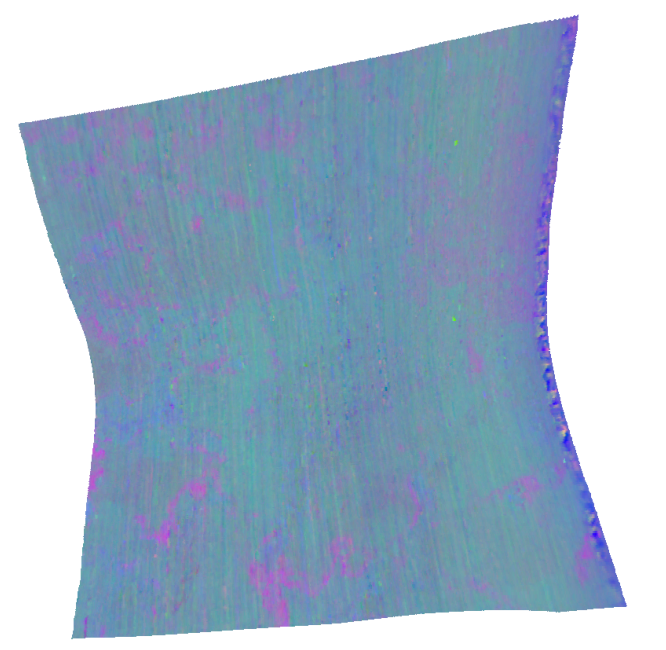

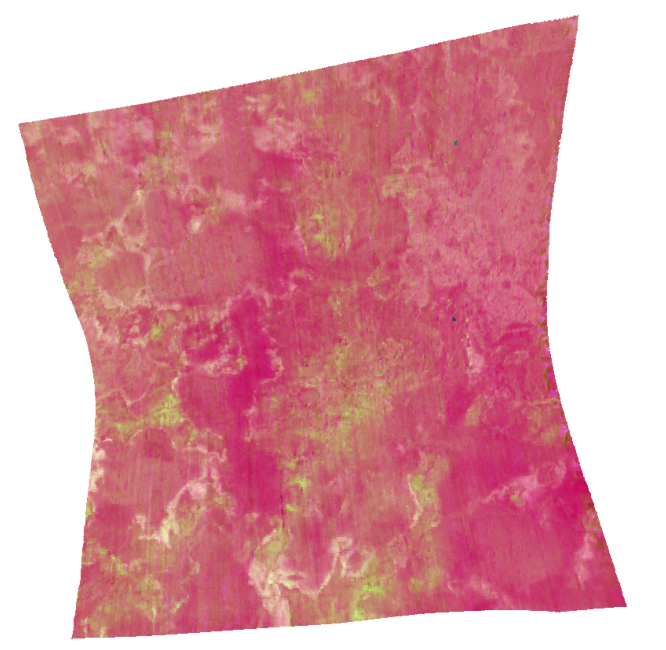

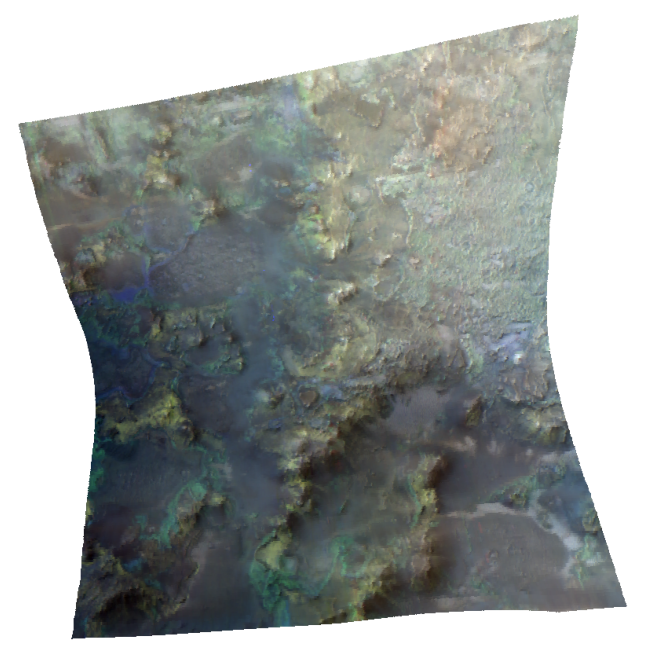

In [276]:
#create RGB composits and plot them
#set figure size base
baseSize=16
#BD2500_2,BD2355,BD2290
plt.figure(figsize=(datacube.shape[1]/datacube.shape[2]*baseSize,datacube.shape[2]/datacube.shape[1]*baseSize),dpi=100)
rgbComposite=np.dstack([BD2500_2,BD2355,BD2290])
plt.imshow(rgbComposite)
plt.axis('off')
plt.box(False)

#BD2500_2,BD2355,BD2290
plt.figure(figsize=(datacube.shape[1]/datacube.shape[2]*baseSize,datacube.shape[2]/datacube.shape[1]*baseSize),dpi=100)
rgbComposite=np.dstack([MIN2295_2480,MIN2345_2537,BD2500_2])
plt.imshow(rgbComposite)
plt.axis('off')
plt.box(False)

#default RGB
plt.figure(figsize=(datacube.shape[1]/datacube.shape[2]*baseSize,datacube.shape[2]/datacube.shape[1]*baseSize),dpi=100)
rgbComposite=np.dstack([datacube[:,:,13],datacube[:,:,78],datacube[:,:,233]])
for i in range(rgbComposite.shape[2]):
    temp=rgbComposite[:,:,i]
    temp=(temp-np.amin(temp[~np.isnan(temp)]))/np.ptp(temp[~np.isnan(temp)])
    temp[np.isnan(temp)]=np.amax(temp[~np.isnan(temp)])
    rgbComposite[:,:,i]=temp
plt.imshow(rgbComposite)
plt.axis('off')
plt.box(False)


In [277]:
#directory to save files
#parameterDirectory="C:/Users/Sandeepan Dhoundiyal/Documents/CRSIMParameterFiles/"
#directory to read files from
#sourceDirectory="/media/sandeepan/Back-up 3/00003E12"
#allObservationAddresses=get_all_processed_HDR_addresses(sourceDirectory) #get file addresses for all '_CAT_corr_p.hdr' files in the Hyperspectral observation directory
i="G:/00003E12/00003e12.hdr"
print(i)
datacube,wavelengthList=preProcessImage(i) #get sliced datacube and list of wavelengths corresponding to bands
#i=i[:i.index('.')]+'.img'
#ds=gdal.Open(i)

G:/00003E12/00003e12.hdr


In [278]:
spectralFileDirectory="G:/CRISM spectral library/crism_resamp/mineral" #directory having library spectras
spectralObjects,spectralFileNames=getspectralObjects(spectralFileDirectory) #get library spectra files as objects and names of all files in the directory
noOfSpectralObjects=len(spectralObjects) #calculate number of spectral objects
print(spectralFileNames)

['carbonate.sli', 'carbonate.sli.hdr', 'inosil.sli', 'inosil.sli.hdr', 'nesosil.sli', 'nesosil.sli.hdr', 'nitrates.hdr', 'nitrates.sli', 'oxide.sli', 'oxide.sli.hdr', 'phosphate.hdr', 'phosphate.sli', 'phylosil.sli', 'phylosil.sli.hdr', 'sorosil.sli', 'sorosil.sli.hdr', 'sulfate.sli', 'sulfate.sli.hdr', 'tectosil.sli', 'tectosil.sli.hdr']


In [279]:

#get indices for the spectras to be skipped  for each type of mineral
noOfSpectralObjects=len(spectralObjects) #calculate number of spectral objects
counter=0
for i in spectralFileNames:
  if i[-3:]=='sli':
    counter=counter+1
#specify filename, first sample name, and mineral family
fileNames=["carbonate.sli",
           "inosil.sli",
           "nesosil.sli",
           "nitrate.sli",
           "oxide.sli",
           "phosphate.sli",
           "phylosil.sli",
           "sorosil.sli",
           "sulfate.sli",
           "tectosil.sli"]
firstSampleNames=["ANKERITE CACB01",
                  "ACTINOLITE C1PA15",
                  "CHRYSOLITE C1PO56",
                  "NITRE KNO3 BIR2NT001",
                  "AKAGANEITE C1092F48",
                  "APATITE LAAP03",
                  "ALLOPHANE LAAL02",
                  "MELILITE C1SC66",
                  "ALUNITE CASF43",
                  "MASKELYNITE LALS91"]
mineralFamilies=["carbonates",
               "pyroxenes",
               "olivines",
               "nitrates",
               "oxides",
               "phosphates",
               "phylosilicates",
               "sorosilicates",
               "sulphates",
               "zeolites"]
#specify indices to ignore for each mineral family
igonoreOlivineIndices=[30,43]
ignoreNitrateIndices=[2,5]
ignorePhyllosilicateIndices=[1,2,3,65,74]
ignoreSulphateIndices=[9,51]
ignorePyroxeneIndices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,55,79,88,89,90,120,122,124,140,143]
ignoreSorosilicateIndices=[8,9]
ignoreCarbonateIndices=[14,38]
ignoreZeoliteIndices=[16,17]
ignoreOxideIndices=[]
ignorePhosphateIndices=[]
#create a list containing the indices to ignore in the same order as mineral families
sampleIndicesToIgnore=[ignoreCarbonateIndices,
                       ignorePyroxeneIndices,
                       igonoreOlivineIndices,
                       ignoreNitrateIndices,
                       ignoreOxideIndices,
                       ignorePhosphateIndices,
                       ignorePhyllosilicateIndices,
                       ignoreSorosilicateIndices,
                       ignoreSulphateIndices,
                       ignoreZeoliteIndices]

In [280]:
#get spectral indices for each type of carbonates
ankerinteIndexRange=[0,5]
aragoniteIndexRange=[6,11]
calciteIndexRange=[12,41]
dolomiteIndexRange=[42,43]
hydromagnesiteIndexRange=[44,55]
magnesiteIndexRange=[56,69]
manganoCalciteIndexRange=[70,75]
northupiteIndexRange=[76,77]
sideriteIndexRange=[78,88]

carbonateIndicestoSkip=[14,38]

carbonateTypeIndices=[ankerinteIndexRange,
                      aragoniteIndexRange,
                      calciteIndexRange,
                      dolomiteIndexRange,
                      hydromagnesiteIndexRange,
                      magnesiteIndexRange,
                      manganoCalciteIndexRange,
                      northupiteIndexRange,
                      sideriteIndexRange
                     ]
carbonateTypeNames=["Ankerinte",
                      "Aragonite",
                      "Calcite",
                      "Dolomite",
                      "Hydromagnesite",
                      "Magnesite",
                      "ManganoCalcite",
                      "Northupite",
                      "Siderite"
                    ]
carbonateTypeNames=["Calcite",
                    "Dolomite",
                    "Magnesite",
                    "Northupite",
                    "Siderite"
                    ]
carbonateTypeIndices=[calciteIndexRange,
                      dolomiteIndexRange,
                      magnesiteIndexRange,
                      northupiteIndexRange,
                      sideriteIndexRange
                     ]

In [281]:
#get indices for samples of each type of phyllosilicates, higher index exclusive
illiteMuscoviteIndices=[10,14]
smectiteIndices=[75,126]
kaoliniteIndices=[14,34]
montmorilloniteIndices=[34,49]
nontroniteIndices=[49,55]
serpentineIndices=[66,74]
talcIndices=[59,66]
chloriteIndices=[7,8]
phyllosilicateTypeIndices=[illiteMuscoviteIndices,
    smectiteIndices,
    kaoliniteIndices,
    montmorilloniteIndices,
    nontroniteIndices,
    serpentineIndices,
    talcIndices,
    chloriteIndices
    ]
pyhllosilicateTypeNames=["Illite",
     "Smectite",
     "Kaolinite",
     "Montmorillonite",
     "Nontronite",
     "Serpentine",
     "Talc",
     "Chlorite"
    ]

In [282]:
#specify range of acceptable values
bandCentre23LowerLimit=2.285
bandCentre23UpperLimit=2.345
bandCentre25LowerLimit=2.485
bandCentre25UpperLimit=2.545
interBandGapLowerLimit=0.19
interBandGapUpperLimit=0.22

In [283]:
#create a dictionary for mineral family and all spectra in it
mineralFamilyNames=[]
mineralFamilySpectra=[]

In [284]:
#iterate over all mineral families
for i in range(len(mineralFamilies)):
    #get the current mineral family
    currentMineralFamily=mineralFamilies[i]
    #set a variable to hold the current spectral object
    currentSpectralObject=''
    #get the spectral object of the current mineral
    for j in spectralObjects:
        librarySpectras,names=getResampledSpectra(j,wavelengthList)
        if names[0]==firstSampleNames[i]:
            currentSpectralObject=j
            break
    #get all spectra and names
    librarySpectras,names=getResampledSpectra(currentSpectralObject,wavelengthList)
    #get number of samples to ignore
    noOfSamplesToIgnore=len(sampleIndicesToIgnore[i])
    #get total number of samples
    totalNoOfSamples=len(names)
    #get number of samples to process
    noOfSamplesToProcess=totalNoOfSamples-noOfSamplesToIgnore
    #show frequencies
    print(f"{currentMineralFamily}--{noOfSamplesToProcess}")
    #save the spectra to be processed
    sampleIndices=np.ones(totalNoOfSamples)
    sampleIndices[:]=True
    sampleIndices[sampleIndicesToIgnore[i]]=False
    mineralFamilyNames.append(currentMineralFamily)
    mineralFamilySpectra.append(librarySpectras[np.where(sampleIndices),:])

carbonates--87
pyroxenes--114
olivines--48
nitrates--4
oxides--90
phosphates--2
phylosilicates--123
sorosilicates--8
sulphates--50
zeolites--46


In [285]:
#define function to identify carbonate using a rule based on five carboante related parameters
def checkCarbonateRule(MIN2295_2480,MIN2345_2537,BD2290,BD2355,BD2500_2,thresholds):
    #create boolean arrays check if each parameter is above the defined threshold
    MIN2295_2480Flags=np.ones_like(MIN2295_2480)
    MIN2345_2537Flags=np.ones_like(MIN2345_2537)
    BD2290Flags=np.ones_like(BD2290)
    BD2355Flags=np.ones_like(BD2355)
    BD2500_2Flags=np.ones_like(BD2500_2)
    
    MIN2295_2480Flags[:]=False
    MIN2345_2537Flags[:]=False
    BD2290Flags[:]=False
    BD2355Flags[:]=False
    BD2500_2Flags[:]=False
    
    #set flags to true where parameteres are greater than thresholds
    MIN2295_2480Flags[MIN2295_2480>thresholds[0]]=True
    MIN2345_2537Flags[MIN2345_2537>thresholds[1]]=True
    BD2290Flags[BD2290>thresholds[2]]=True
    BD2355Flags[BD2355>thresholds[3]]=True
    BD2500_2Flags[BD2500_2>thresholds[4]]=True
    
    #define the rule 
    #if 
    #MIN2295_2480 is True
    #or
    #MIN2345_2537 is True
    #or
    #(BD2290 is True or BD2355 is True) and BD2500_2 is True
    #
    #then
    #spectra is carbonate
    carbonateFlags=MIN2295_2480Flags+MIN2345_2537Flags+((BD2290Flags+BD2355Flags)*BD2500_2Flags)
    
    return carbonateFlags

C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:128: RuntimeWarning: invalid value encountered in true_divide
  BD2290=1-R2290Reflectance/(a*R2250Reflectance+b*R2350Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:154: RuntimeWarning: invalid value encountered in true_divide
  BD2355=1-R2355Reflectance/(a*R2300Reflectance+b*R2450Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:102: RuntimeWarning: invalid value encountered in true_divide
  BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)


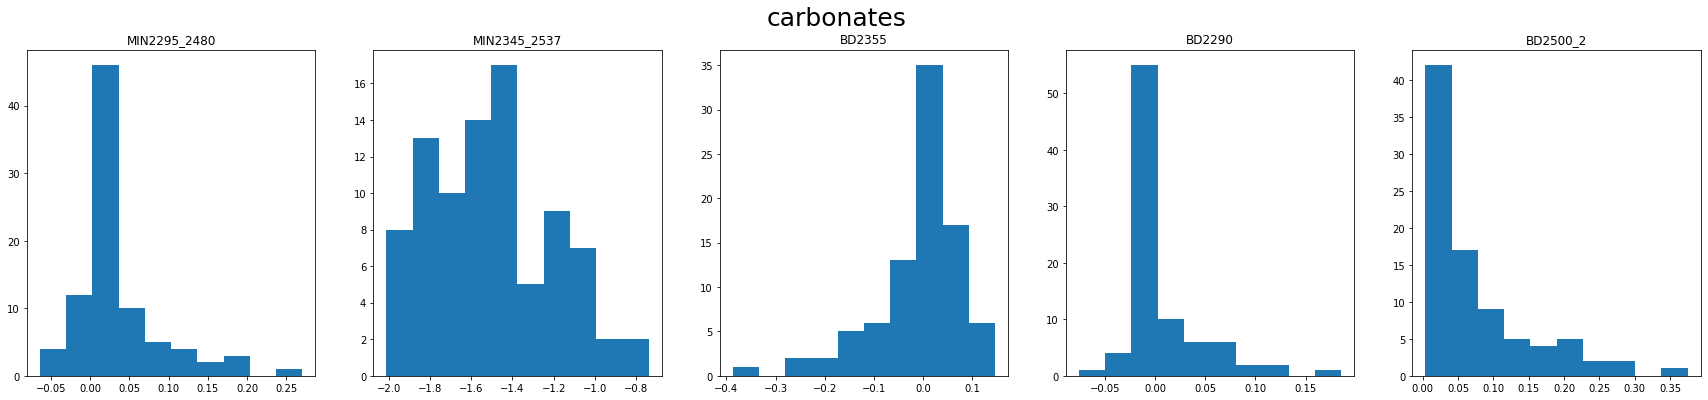

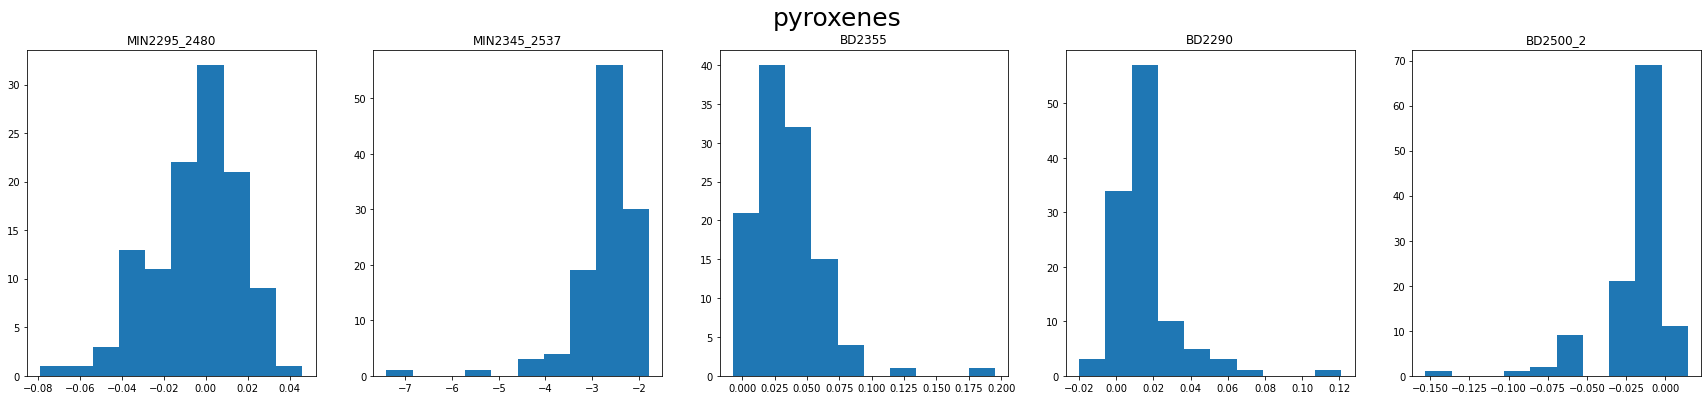

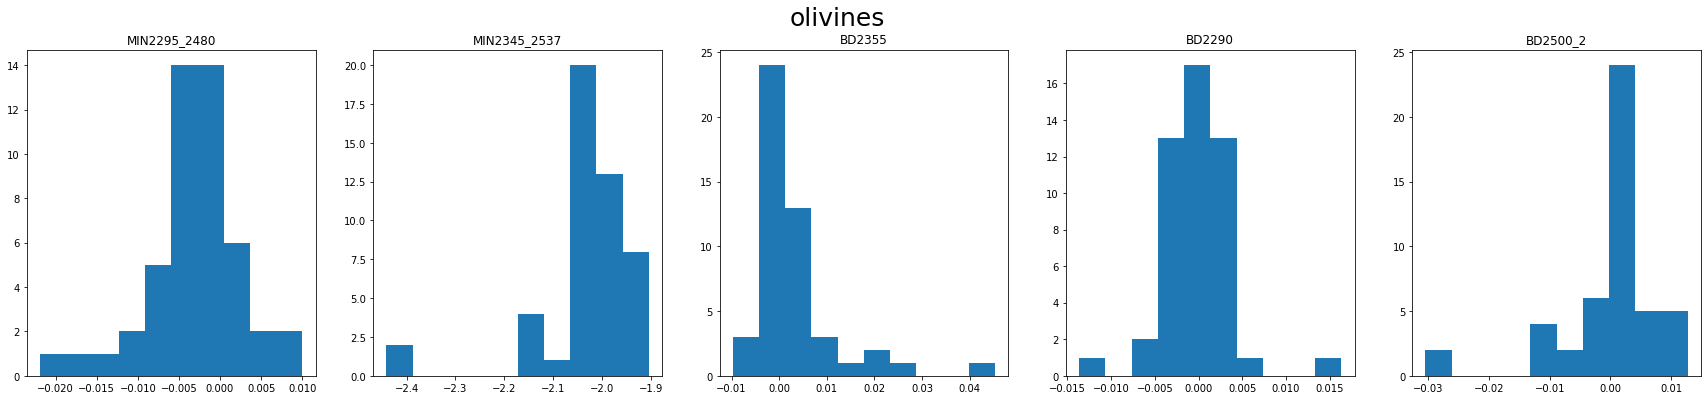

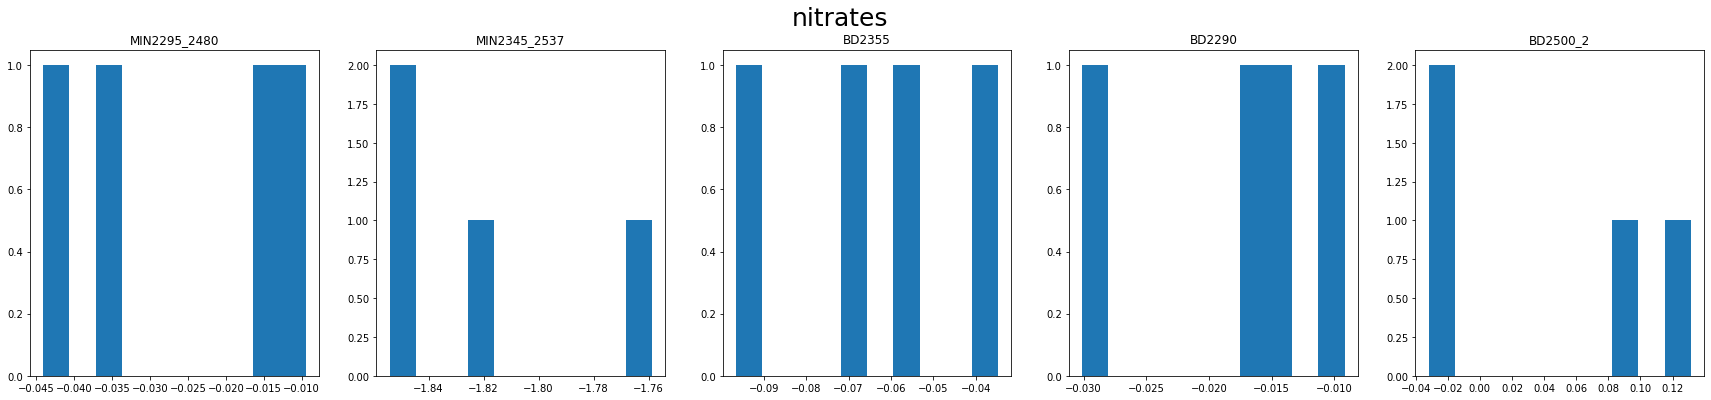

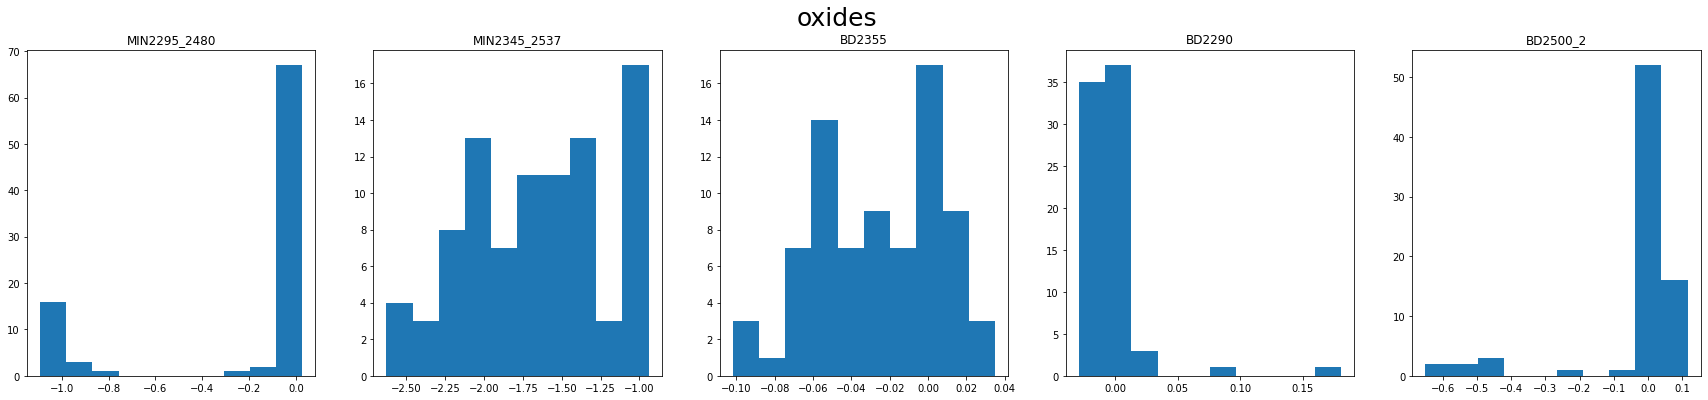

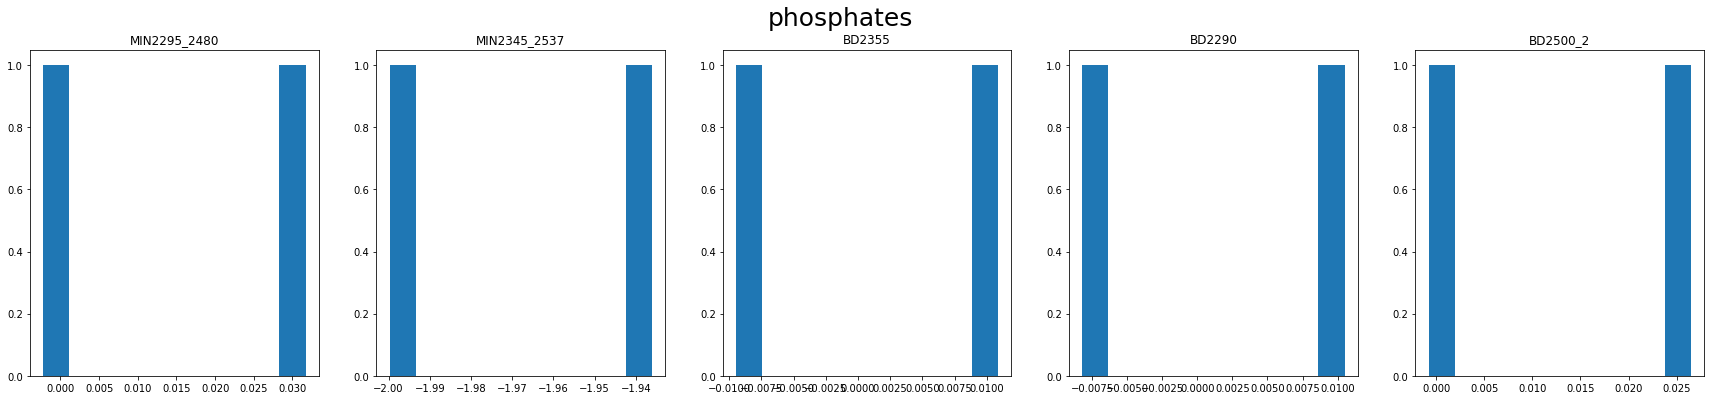

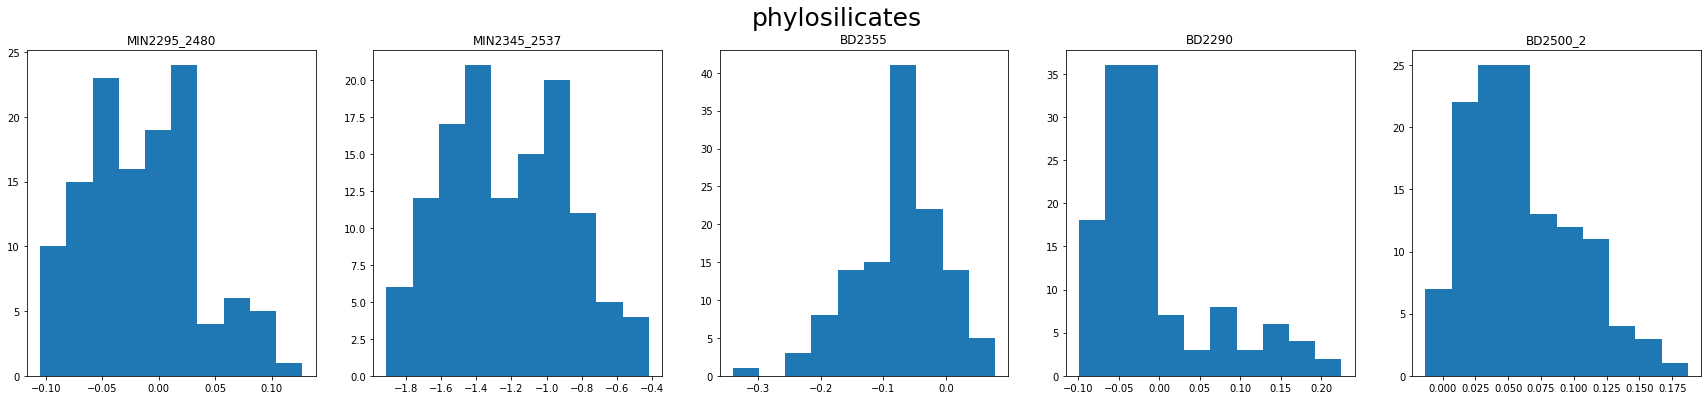

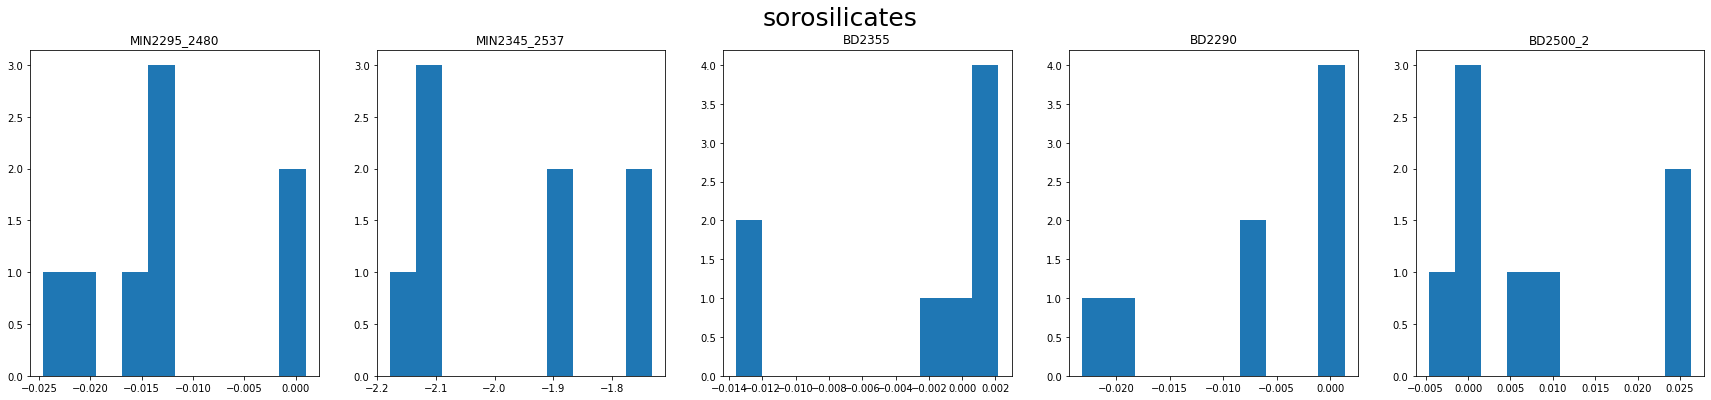

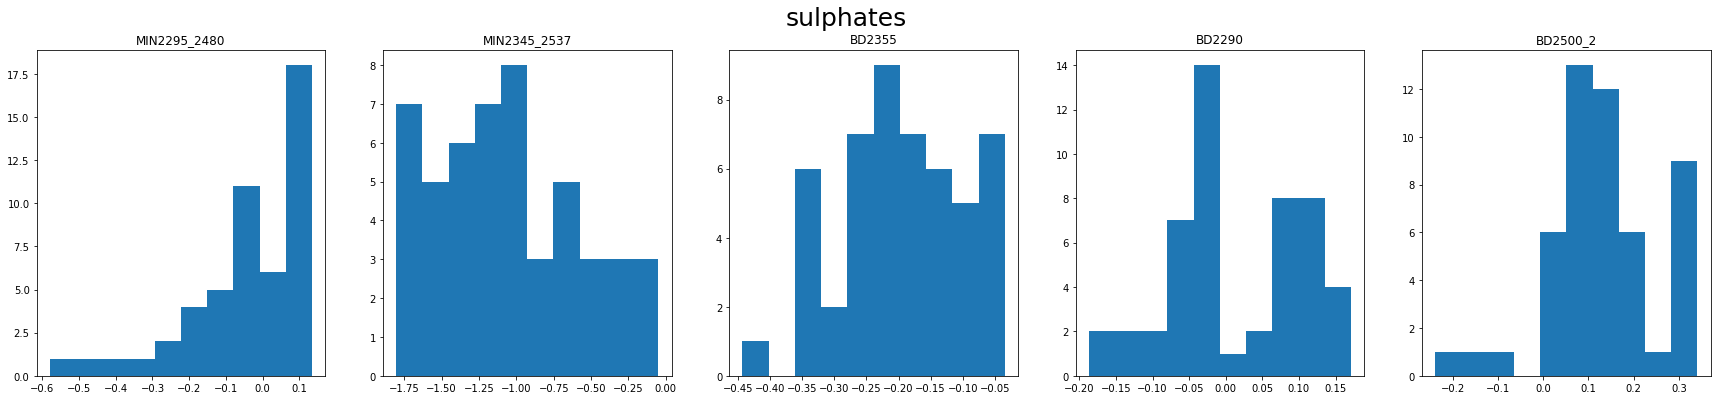

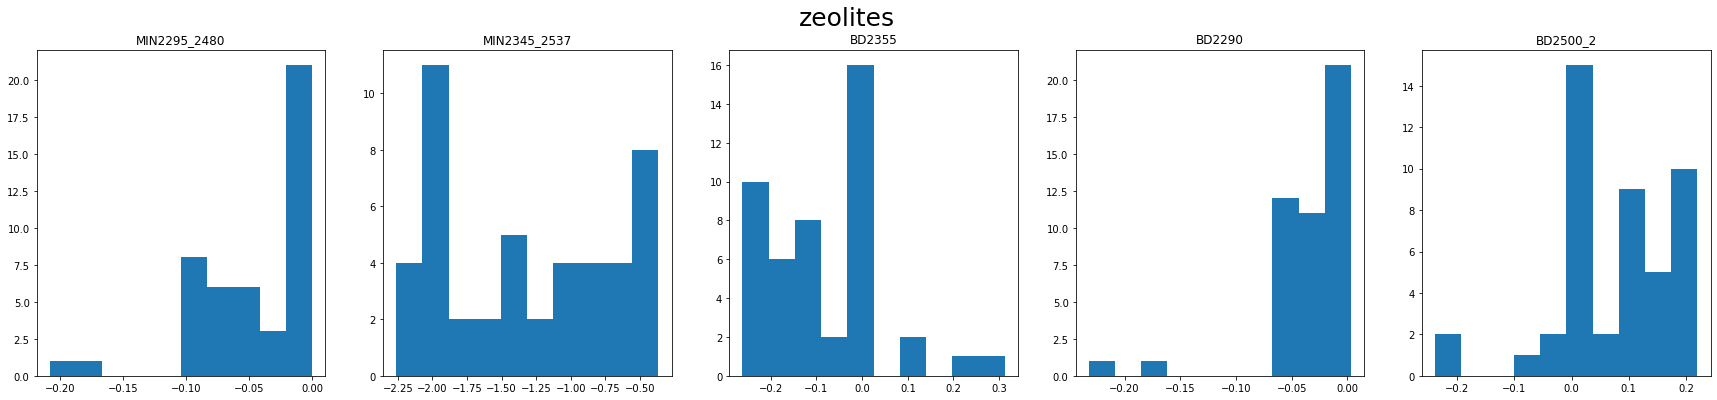

In [286]:
#iterate over each mineral family
for i in range(len(mineralFamilyNames)):
    #get all scpectra in current family
    currentSpectraSet=mineralFamilySpectra[i]
    currentSpectraSet=currentSpectraSet[0,:,:]
    #set the current array as the datacube (done so I don'y have to write extra code and the code written to process datacubes can be used to process a asimple array)
    slicedCube=datacube=currentSpectraSet
    #calculate MIN indices
    MIN2295_2480,MIN2345_2537=calculateMIN23AND25Spectra()
    #calculate OLINDEX3
    BD2290=calcBD2290Spectra()
    #calculate D2300
    BD2355=calcBD2355Spectra()
    #calculate BD2500_2
    BD2500_2=calcBD2500_2Spectra()
    plt.figure(figsize=(30,6))
    plt.suptitle(mineralFamilyNames[i],fontsize=25)
    plt.subplot(1,5,1)
    plt.title("MIN2295_2480")
    t=plt.hist(MIN2295_2480)
    
    plt.subplot(1,5,2)
    plt.title("MIN2345_2537")
    t=plt.hist(MIN2345_2537)
    
    plt.subplot(1,5,3)
    plt.title("BD2355")
    t=plt.hist(BD2355)
    
    plt.subplot(1,5,4)
    plt.title("BD2290")
    t=plt.hist(BD2290)
    
    plt.subplot(1,5,5)
    plt.title("BD2500_2")
    t=plt.hist(BD2500_2)
    

In [287]:
#thresholds=np.array([0,0,0,0,0])
thresholds=[-0.06,-0.05,0,-0.05,0]

#iterate over each non-carbonate mineral family
for i in range(1):
    #get all scpectra in current family
    currentSpectraSet=mineralFamilySpectra[i]
    currentSpectraSet=currentSpectraSet[0,:,:]
    #set the current array as the datacube (done so I don'y have to write extra code and the code written to process datacubes can be used to process a asimple array)
    slicedCube=datacube=currentSpectraSet
    #calculate MIN indices
    MIN2295_2480,MIN2345_2537=calculateMIN23AND25Spectra()
    #calculate OLINDEX3
    BD2290=calcBD2290Spectra()
    #calculate D2300
    BD2355=calcBD2355Spectra()
    #calculate BD2500_2
    BD2500_2=calcBD2500_2Spectra()
    
    carbonateFlags=checkCarbonateRule(MIN2295_2480,MIN2345_2537,BD2290,BD2355,BD2500_2,thresholds)
    samplesClassifiedAsCarbonates=len(np.where(carbonateFlags>0)[0])
    samplesClassifiedAsNonCarbonates=len(np.where(carbonateFlags==0)[0])
    print(f"\n\n{mineralFamilyNames[i]}-{samplesClassifiedAsNonCarbonates+samplesClassifiedAsCarbonates}")
    print(f"Percent carbonate-{round(samplesClassifiedAsCarbonates/(samplesClassifiedAsCarbonates+samplesClassifiedAsNonCarbonates),2)}")
    print(f"Percent non-carbonate-{round(samplesClassifiedAsNonCarbonates/(samplesClassifiedAsCarbonates+samplesClassifiedAsNonCarbonates),2)}")

totalFalseCarbonates=0
totalTrueNonCarbonates=0
#iterate over each non-carbonate mineral family
for i in range(len(mineralFamilyNames)):
    #get all scpectra in current family
    currentSpectraSet=mineralFamilySpectra[i]
    currentSpectraSet=currentSpectraSet[0,:,:]
    #set the current array as the datacube (done so I don'y have to write extra code and the code written to process datacubes can be used to process a asimple array)
    slicedCube=datacube=currentSpectraSet
    #calculate MIN indices
    MIN2295_2480,MIN2345_2537=calculateMIN23AND25Spectra()
    #calculate OLINDEX3
    BD2290=calcBD2290Spectra()
    #calculate D2300
    BD2355=calcBD2355Spectra()
    #calculate BD2500_2
    BD2500_2=calcBD2500_2Spectra()
    
    carbonateFlags=checkCarbonateRule(MIN2295_2480,MIN2345_2537,BD2290,BD2355,BD2500_2,thresholds)
    
    samplesClassifiedAsCarbonates=len(np.where(carbonateFlags>0)[0])
    samplesClassifiedAsNonCarbonates=len(np.where(carbonateFlags==0)[0])
    
    totalFalseCarbonates=totalFalseCarbonates+samplesClassifiedAsCarbonates
    totalTrueNonCarbonates=totalTrueNonCarbonates+samplesClassifiedAsNonCarbonates
    
    #print(f"Percent carbonate-{round(samplesClassifiedAsCarbonates/(samplesClassifiedAsCarbonates+samplesClassifiedAsNonCarbonates),2)}")
    #print(f"Percent non-carbonate-{round(samplesClassifiedAsNonCarbonates/(samplesClassifiedAsCarbonates+samplesClassifiedAsNonCarbonates),2)}")

print(f"\n\nNon-Carbonates-{totalFalseCarbonates+totalTrueNonCarbonates}")
print(f"Percent carbonate-{round(totalFalseCarbonates/(totalFalseCarbonates+totalTrueNonCarbonates),2)}")
print(f"Percent non-carbonate-{round(totalTrueNonCarbonates/(totalFalseCarbonates+totalTrueNonCarbonates),2)}")



carbonates-87
Percent carbonate-1.0
Percent non-carbonate-0.0


Non-Carbonates-572
Percent carbonate-0.86
Percent non-carbonate-0.14


C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:128: RuntimeWarning: invalid value encountered in true_divide
  BD2290=1-R2290Reflectance/(a*R2250Reflectance+b*R2350Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:154: RuntimeWarning: invalid value encountered in true_divide
  BD2355=1-R2355Reflectance/(a*R2300Reflectance+b*R2450Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_7868/1533483615.py:102: RuntimeWarning: invalid value encountered in true_divide
  BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)
